In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('/global/homes/q/qmxp55/DESI/omarlibs')
import raichoorlib
import numpy as np
np.seterr(divide='ignore') # ignode divide by zero warnings
import astropy.io.fits as fits
import fitsio
import glob
import healpy as hp
from astropy.coordinates import SkyCoord
import astropy.units as units
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from main_def import get_random, flux_to_mag, get_sweep_whole, bgsmask, getGeoCuts
from photometric_def import get_stars, get_galaxies
from main_def import get_random, hexbin

import seaborn as sns
sns.set()


## Input files

In [2]:
#input files

inptfiles = {}

#inptfiles['dr8randroot']= '/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randoms/randoms-inside-dr8-0.31.0-'
inptfiles['dr8pix']     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
inptfiles['desitile']   = '/global/cscratch1/sd/raichoor/desi-tiles-viewer.fits' # from Eddie, see [desi-survey 647]
inptfiles['bgsdr8']   = '/global/cscratch1/sd/qmxp55/bgs_dr8_0.31.1+cuts.npy'
inptfiles['bgssvtiles'] = '/global/cscratch1/sd/qmxp55/BGS_SV_30_3x_superset60_JUL2019.fits'
inptfiles['bgsdr8relax'] = '/global/cscratch1/sd/qmxp55/bgs_dr8_0.31.1_relaxed.npy'
inptfiles['dr8maskbitsource'] = '/global/cscratch1/sd/qmxp55/sweep_files/dr8_sweep_whole_maskbitsource.npy'
#inptfiles['gama_dr3'] = '/project/projectdirs/desi/target/analysis/truth/parent/GAMA-DR3-SpecObj.fits'
inptfiles['gama_dr3'] = '/global/cscratch1/sd/qmxp55/TilingCatv46.fits'

#inptfiles['bgsdr8relax-north'] = '/global/cscratch1/sd/qmxp55/desitarget_output/targets-BGS-main-dr8.0-1-north.fits'
#inptfiles['bgsdr8relax-south'] = '/global/cscratch1/sd/qmxp55/desitarget_output/targets-BGS-main-dr8.0-1-south.fits'

for file in inptfiles.keys():
    print(file, '\t=', inptfiles[file])


dr8pix 	= /project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits
desitile 	= /global/cscratch1/sd/raichoor/desi-tiles-viewer.fits
bgsdr8 	= /global/cscratch1/sd/qmxp55/bgs_dr8_0.31.1+cuts.npy
bgssvtiles 	= /global/cscratch1/sd/qmxp55/BGS_SV_30_3x_superset60_JUL2019.fits
bgsdr8relax 	= /global/cscratch1/sd/qmxp55/bgs_dr8_0.31.1_relaxed.npy
dr8maskbitsource 	= /global/cscratch1/sd/qmxp55/sweep_files/dr8_sweep_whole_maskbitsource.npy
gama_dr3 	= /global/cscratch1/sd/qmxp55/TilingCatv46.fits


The input files needed for this notebook are:

* dr8randroot: the randoms of LS DR8 created by DESITARGET. These are divided into 10 fits files each one with a target density of 5000. For more info go to: http://legacysurvey.org/dr8/files/#random-catalogs
* dr8pix: the healpix pixel weights map. Includes information such as the stellar density from GAIA DR2, the extinction, the psfsizes and galdepths for the three bands.
* desitile: the tiles pattern for the DESI footprint (~14000 deg^2). Includes tiles centers.
* bgssvdr8: the BGS SV catalogue. Include the DESITARGET columns to select the supersets and magnitudes in the three bands plus the fiber magnitude in the r-band.

In [3]:
gama_ = fitsio.read(inptfiles['gama_dr3'], ext=1)
# get only good quality gama objects
gama = gama_[(gama_['SURVEY_CLASS'] >= 4) & (gama_['NQ'] >= 3)]
print('fraction of gama good quality: %i / %i' %(len(gama), len(gama_)))

fraction of gama good quality: 186137 / 221373


In [4]:
gamafield = np.empty_like(gama['RA'], dtype='S4')
for i, field in enumerate(gama['SPECID']):
    #print(i, field[:3])
    if field[:1] == 'G': gamafield[i] = field[:3]
    else: gamafield[i] = 'OTHR'
        

b'OTHR' 22049
	 -- 129 < RA < 223.5, -- -2.999 < DEC < 2.999
b'G15' 53923
	 -- 211.5 < RA < 223.5, -- -1.999 < DEC <   3
b'G09' 55758
	 -- 129 < RA < 141, --  -2 < DEC <   3
b'G12' 54407
	 -- 174 < RA < 186, --  -3 < DEC <   2


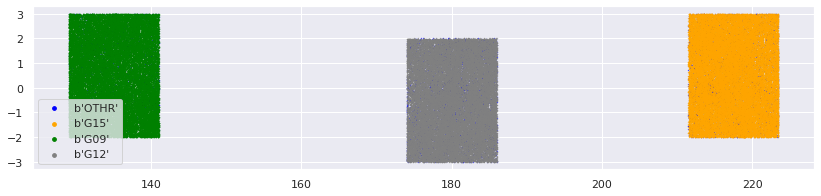

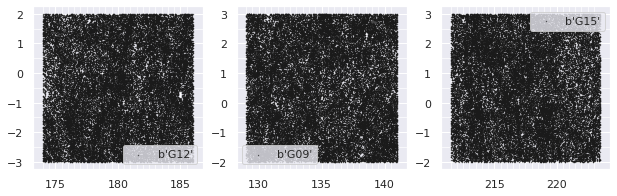

In [5]:
#
plt.figure(figsize=(14,3))
for j, i in enumerate(list(set(gamafield))[::-1]):
    clr = ['blue', 'orange', 'green', 'gray']
    mask = gamafield == i
    print(i, np.sum(mask))
    print('\t -- %3.4g < RA < %3.4g, -- %3.4g < DEC < %3.4g' 
          %(gama['RA'][mask].min(), gama['RA'][mask].max(), gama['DEC'][mask].min(), gama['DEC'][mask].max()))
    #if i == b'OTHR': color='gray'
    #else: 
    plt.scatter(gama['RA'][mask], gama['DEC'][mask], s=0.1, color=clr[j], label=i)
#plt.legend()
    lgnd = plt.legend()
    [handle.set_sizes([14.0]) for handle in lgnd.legendHandles]
#plt.grid()
plt.show()

fig = plt.figure(figsize=(14,3))
for num, i in enumerate(set(gamafield)):
    if i == b'OTHR': continue
    ax = fig.add_subplot(1, 4, num+1)
    mask = gamafield == i
    ramin, ramax, decmin, decmax = gama['RA'][mask].min(), gama['RA'][mask].max(), gama['DEC'][mask].min(), gama['DEC'][mask].max()
    minor_ticks_x = np.arange(ramin, ramax, 0.5)
    minor_ticks_y = np.arange(decmin, decmax, 0.5)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(minor_ticks_y, minor=True)
    
    #plt.subplot(1, 4, num+1)
    ax.scatter(gama['RA'][mask], gama['DEC'][mask], s=0.1, c='k',label=i)
    ax.legend()
    ax.grid(which='minor', alpha=0.7)


In [6]:
def get_isgama(ra, dec):
    
    keep = np.zeros_like(ra, dtype='?')

    #keep |= ((ra > 30.2) & (ra < 38.8) & (dec > -10.2) & (dec < -3.72)) #G02
    keep |= ((ra > 174.) & (ra < 186.) & (dec > -3.) & (dec < 2.)) #G12
    keep |= ((ra > 211.5) & (ra < 223.5) & (dec > -2.) & (dec < 3.)) #G15
    keep |= ((ra > 129.) & (ra < 141.) & (dec > -2.) & (dec < 3.)) #G09
    
    return keep


In [7]:
# load catalogue
# this is dr8 sweeps in decals with BGSBITS 
cat =  get_sweep_whole(dr='dr8-south', rlimit=20, maskbitsource=False, bgsbits=True, opt='1')


sweep file already exist at:/global/cscratch1/sd/qmxp55/sweep_files/dr8-south_sweep_whole_rlimit_20.npy
Total run time: 0.000573 sec


In [8]:
# masks
catisgama = get_isgama(cat['RA'], cat['DEC']) #cat in GAMA footprint

In [9]:

# get LS objects with BS, LG, GC and NOBS bit set on
from main_def import bgsmask

catbutgeo = np.ones_like(cat['RA'], dtype='?')
for key in ['BS', 'LG', 'GC', 'nobs']:
    catbutgeo &= (cat['BGSBITS'] & 2**(bgsmask()[key])) != 0
        

## Compute reduced area with the randoms

In [10]:
randoms = get_random(N=3, sweepsize=None, dr='dr8') # randoms

RANDOM file already exist at:/global/cscratch1/sd/qmxp55/dr8_random_N3.npy
Total run time: 0.001167 sec
Weight of /global/cscratch1/sd/qmxp55/dr8_random_N3.npy catalogue: 6.82 GB


In [11]:
# stick with randoms in GAMA only
randoms = randoms[get_isgama(randoms['RA'], randoms['DEC'])]

rancuts = getGeoCuts(randoms)

ranbutgeo = np.ones_like(randoms['RA'], dtype='?')
for key in ['BS', 'LG', 'GC', 'nobs']:
    ranbutgeo &= rancuts[key]
    
A = 59.98*3 # area of the 3 GAMA fields footprint in deg^2
Ared = A*(np.sum(ranbutgeo)/len(randoms))
    
print('fraction of randoms after GEO mask: %i / %i' %(np.sum(ranbutgeo), len(randoms)))
print('Area within the 3 GAMA fields: %2.3g' %(A))
print('reduced area within the 3 GAMA fields after GEO mask: %2.3g' %(Ared))


fraction of randoms after GEO mask: 2624853 / 2698449
Area within the 3 GAMA fields: 180
reduced area within the 3 GAMA fields after GEO mask: 175


## Match BGS catalogue with GAMA DR3

In [12]:
# dr8 in gama + GEO mask
dr8ingama = cat[(catisgama) & (catbutgeo)]

In [13]:
# bgs mask
bgs = (dr8ingama['BGSBITS'] & 2**(15)) != 0
print('fraction of bgs in dr8 within GAMA: %i / %i' %(np.sum(bgs), len(dr8ingama)))

fraction of bgs in dr8 within GAMA: 251576 / 828676


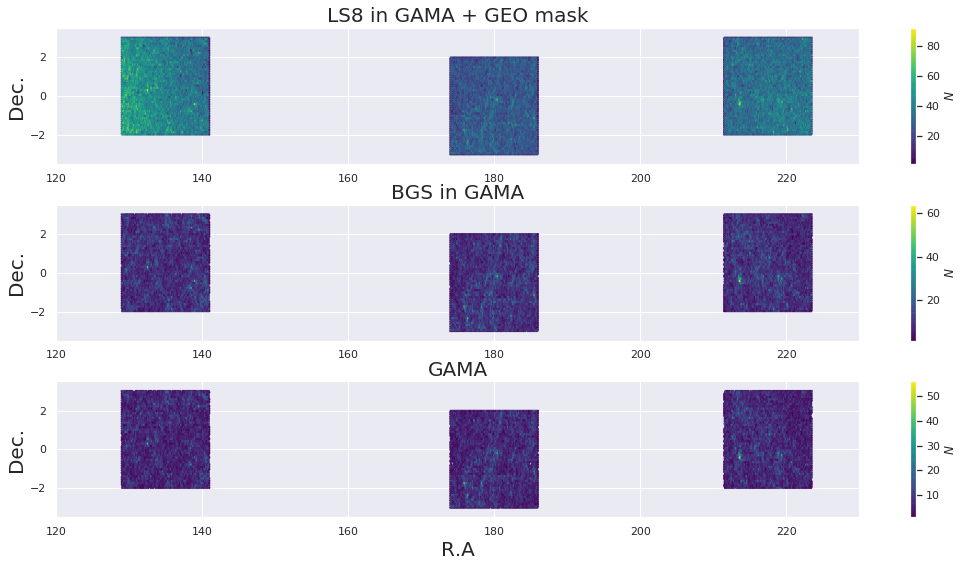

In [14]:
#
fig    = plt.figure(figsize=(18, 9))
gs     = gridspec.GridSpec(3, 1, hspace=0.30)

coord = {'R.A': dr8ingama['RA'], 'Dec.':dr8ingama['DEC']}
hexbin(coord=coord, catmask=None, n=0, title='LS8 in GAMA + GEO mask', cmap='viridis', xlab=False, 
           fig=fig, gs=gs, xlim=(120, 230), ylim=(-3.5, 3.5), gridsize=(750, 50), comp=False)

coord = {'R.A': dr8ingama['RA'][bgs], 'Dec.':dr8ingama['DEC'][bgs]}
hexbin(coord=coord, catmask=None, n=1, title='BGS in GAMA', cmap='viridis', xlab=False, 
           fig=fig, gs=gs, xlim=(120, 230), ylim=(-3.5, 3.5), gridsize=(750, 50), comp=False)

coord = {'R.A': gama['RA'], 'Dec.':gama['DEC']}
hexbin(coord=coord, catmask=None, n=2, title='GAMA', cmap='viridis',
           fig=fig, gs=gs, xlim=(120, 230), ylim=(-3.5, 3.5), gridsize=(750, 50), comp=False)


In [15]:
# matching LS8 with gama
idx2, idx1, d2d, d_ra, d_dec = raichoorlib.match_coord(dr8ingama['RA'], dr8ingama['DEC'], gama['RA'], gama['DEC'], search_radius=0.5)

# matching gama with bgs
#idx2g, idx1g, d2dg, d_rag, d_decg = raichoorlib.search_around(gama['RA'], gama['DEC'], bgsingama['RA'], bgsingama['DEC'], search_radius=1)

Doubly matched objects = 0
Final matched objects = 174766


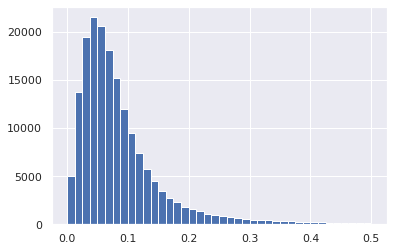

In [16]:
plt.hist(d2d, 40)
plt.show()

In [17]:
gama.dtype.names

('CATAID',
 'OBJID',
 'RA',
 'DEC',
 'FIBERMAG_R',
 'R_PETRO',
 'U_MODEL',
 'G_MODEL',
 'R_MODEL',
 'I_MODEL',
 'Z_MODEL',
 'SURVEY_CODE',
 'Z',
 'NQ',
 'NQ2_FLAG',
 'SPECID',
 'VEL_ERR',
 'NUM_GAMA_SPEC',
 'R_SB',
 'SG_SEP',
 'SG_SEP_JK',
 'K_AUTO',
 'RADIO_FLUX',
 'HATLAS_FLAG',
 'AREA_FLAG',
 'TARGET_FLAGS',
 'SURVEY_OLDCLASS',
 'SURVEY_CLASS',
 'PRIORITY_CLASS',
 'NEIGHBOUR_CLASS',
 'TC_V11_ID',
 'MASK_IC_10',
 'MASK_IC_12',
 'VIS_CLASS',
 'VIS_CLASS_USER')

In [18]:
# bgs matched with gama
dr8_gama = np.zeros_like(dr8ingama['RA'], dtype='?') #dr8 that match with gama
dr8_z = np.full_like(dr8ingama['RA'], -1) #z from gama
dr8_rmodel = dr8_z.copy() #r model mag from gama
dr8_sclass = dr8_z.copy() #survey class from gama
dr8_nq = dr8_z.copy() #quality of redshift from gama

dr8_gama[idx2.tolist()] = True
dr8_z[idx2.tolist()] = gama['Z'][idx1]
dr8_rmodel[idx2.tolist()] = gama['R_PETRO'][idx1]
dr8_sclass[idx2.tolist()] = gama['SURVEY_CLASS'][idx1]
dr8_nq[idx2.tolist()] = gama['NQ'][idx1]

# gama matched with bgs
gama_dr8 = np.zeros_like(gama['Z'], dtype='?')
gama_bgs = gama_dr8.copy()
gama_dr8[idx1.tolist()] = True
gama_bgs[idx1.tolist()] = bgs[idx2]


In [19]:
# making a common catalogue
from astropy.table import Table
Tdr8 = Table()
Tgama = Table()

Tdr8['dr8'] = np.ones_like(dr8ingama['RA'], dtype='?')
Tdr8['gama'] = dr8_gama
Tdr8['bgs'] = bgs

notingama = np.zeros(np.sum(~gama_dr8), dtype='?')
Tgama['dr8'] = notingama
Tgama['gama'] = ~notingama
Tgama['bgs'] = notingama

tab = np.concatenate((Tdr8, Tgama))


In [20]:
from matplotlib_venn import venn3, venn3_circles
def plot_venn3(A, B, C, norm=None, labels=None):
    '''inputs A, B, C must booleans.'''
    
    A1 = A
    B1 = B
    C1 = C
    AB = (A1) & (B1)
    AC = (A1) & (C1)
    BC = (B1) & (C1)
    ABC = (A1) & (B1) & (C1)
            
    if norm is None: norm, sf = 1, 1
    else: sf = 1
        
    a1 = round((np.sum(A1) - np.sum(AB) - np.sum(AC) + np.sum(ABC))/norm, sf)
    a2 = round((np.sum(B1) - np.sum(AB) - np.sum(BC) + np.sum(ABC))/norm, sf)
    a3 = round((np.sum(AB) - np.sum(ABC))/norm, sf)
    a4 = round((np.sum(C1) - np.sum(AC) - np.sum(BC) + np.sum(ABC))/norm, sf)
    a5 = round((np.sum(AC) - np.sum(ABC))/norm, sf)
    a6 = round((np.sum(BC) - np.sum(ABC))/norm, sf)
    a7 = round(np.sum(ABC)/norm, sf)
        
    if labels is None: labels = ['Group A', 'Group B', 'Group C']
        
    plt.figure(figsize=(7,7))
    v=venn3([a1, a2, a3, a4, a5, a6, a7], set_labels = (labels[0], labels[1], labels[2]))
    c=venn3_circles([a1, a2, a3, a4, a5, a6, a7], linestyle='dotted', linewidth=1, color="grey")
    #c[1].set_lw(1.0)
    c[1].set_ls('solid')
    c[2].set_ls('dashed')
    #c[1].set_color('skyblue')

    plt.show()

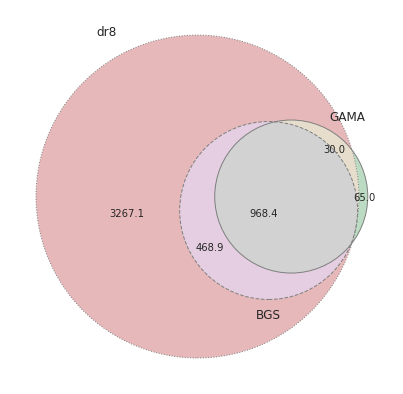

In [30]:
#
plot_venn3(A=tab['dr8'], B=tab['gama'], C=tab['bgs'], norm=Ared, labels=['dr8', 'GAMA', 'BGS'])


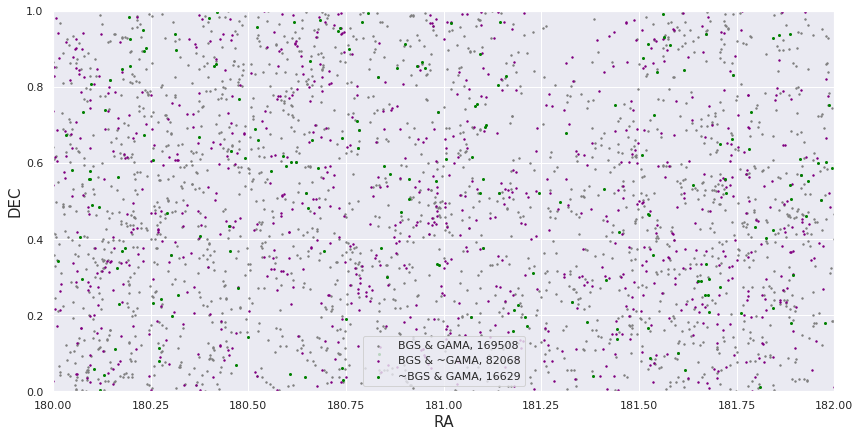

In [22]:
#
plt.figure(figsize=(14, 7))

plt.scatter(dr8ingama['RA'][(dr8_gama) & (bgs)], dr8ingama['DEC'][(dr8_gama) & (bgs)], s=2, color='gray', label=r'BGS & GAMA, %i' %(np.sum((dr8_gama) & (bgs))))
plt.scatter(dr8ingama['RA'][(~dr8_gama) & (bgs)], dr8ingama['DEC'][(~dr8_gama) & (bgs)], s=2, color='purple', label=r'BGS & ~GAMA, %i' %(np.sum((~dr8_gama) & (bgs))))
plt.scatter(gama['RA'][~gama_bgs], gama['DEC'][~gama_bgs], s=4, color='green', label=r'~BGS & GAMA, %i' %(np.sum(~gama_bgs)))

plt.xlabel(r'RA', size=15)
plt.ylabel(r'DEC', size=15)
plt.xlim(180, 182)
plt.ylim(0, 1)
plt.legend()


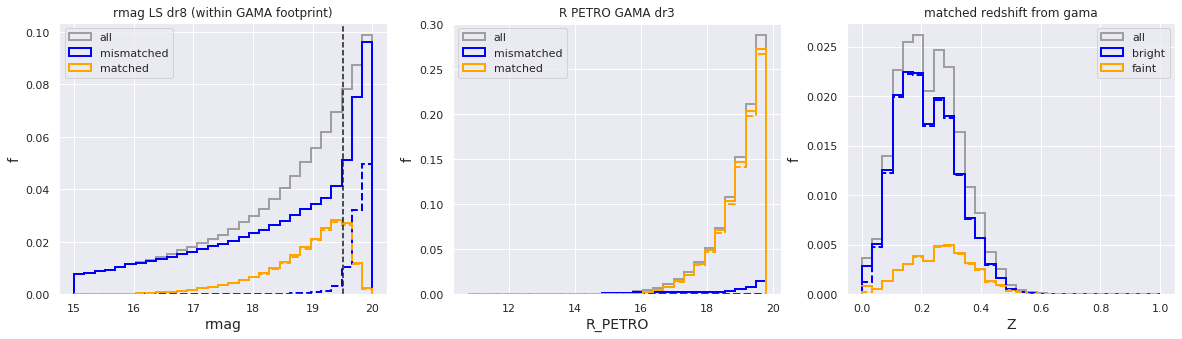

In [23]:
plt.figure(figsize=(20,5))
N = len(dr8ingama['RA'])
cumu = False
plt.subplot(1,3,1)
bins = np.linspace(15, 20, 30)
plt.title(r'rmag LS dr8 (within GAMA footprint)')
plt.hist(dr8ingama['RMAG'], bins=bins, weights=np.full(N, 1/N), histtype='step',cumulative=cumu, lw=2, color='gray', alpha=0.7, label='all')
plt.hist(dr8ingama['RMAG'][~dr8_gama], bins=bins, weights=np.full(np.sum(~dr8_gama), 1/N), histtype='step', cumulative=cumu, lw=2, color='blue', label='mismatched')
plt.hist(dr8ingama['RMAG'][dr8_gama], bins=bins, weights=np.full(np.sum(dr8_gama), 1/N), histtype='step',cumulative=cumu, lw=2, color='orange', label='matched')
plt.hist(dr8ingama['RMAG'][(~dr8_gama) & (bgs)], bins=bins, weights=np.full(np.sum((~dr8_gama) & (bgs)), 1/N), histtype='step', cumulative=cumu, lw=2, ls='--', color='blue')
plt.hist(dr8ingama['RMAG'][(dr8_gama) & (bgs)], bins=bins, weights=np.full(np.sum((dr8_gama) & (bgs)), 1/N), histtype='step',cumulative=cumu, lw=2, ls='--', color='orange')
plt.xlabel(r'rmag', size=14)
plt.ylabel(r'f', size=14)
plt.legend(loc='upper left')
plt.axvline(19.5, ls='--', c='k')

plt.subplot(1,3,2)
Ng = len(gama['R_PETRO'])
ylim = np.percentile(gama['R_PETRO'][(gama['R_PETRO'] > 0) & (np.isfinite(gama['R_PETRO']))],(0,99.5))
mask0 = (gama['R_PETRO'] > ylim[0]) & (gama['R_PETRO'] < ylim[1])
bins = np.linspace(ylim[0], ylim[1], 30)
plt.title(r'R PETRO GAMA dr3')
plt.hist(gama['R_PETRO'][mask0], bins=bins, weights=np.full(np.sum(mask0), 1/Ng), histtype='step',cumulative=cumu, lw=2, color='gray', alpha=0.7, label='all')
plt.hist(gama['R_PETRO'][(mask0) & (~gama_dr8)], bins=bins, weights=np.full(np.sum((mask0) & (~gama_dr8)), 1/Ng), histtype='step', cumulative=cumu, lw=2, color='blue',label='mismatched')
plt.hist(gama['R_PETRO'][(mask0) & (gama_dr8)], bins=bins, weights=np.full(np.sum((mask0) & (gama_dr8)), 1/Ng), histtype='step',cumulative=cumu, lw=2, color='orange',label='matched')
plt.hist(gama['R_PETRO'][(mask0) & (~gama_dr8) & (gama_bgs)], bins=bins, weights=np.full(np.sum((mask0) & (~gama_dr8) & (gama_bgs)), 1/Ng), histtype='step', cumulative=cumu, lw=2, ls='--', color='blue')
plt.hist(gama['R_PETRO'][(mask0) & (gama_dr8) & (gama_bgs)], bins=bins, weights=np.full(np.sum((mask0) & (gama_dr8) & (gama_bgs)), 1/Ng), histtype='step',cumulative=cumu, lw=2, ls='--', color='orange')
plt.xlabel(r'R_PETRO', size=14)
plt.ylabel(r'f', size=14)
plt.legend(loc='upper left')
#plt.axvline(19.5, ls='--', c='k')

plt.subplot(1,3,3)
mask = (dr8_gama) & (dr8_z > 0) & (dr8_z < 1)
maskB = (dr8_gama) & (dr8_z > 0) & (dr8_z < 1) & (dr8ingama['RMAG'] < 19.5)
maskF = (dr8_gama) & (dr8_z > 0) & (dr8_z < 1) & (dr8ingama['RMAG'] > 19.5) & (dr8ingama['RMAG'] < 20.)
bins = np.linspace(0,1,30)

plt.title(r'matched redshift from gama')
plt.hist(dr8_z[mask], bins=bins,  weights=np.full(np.sum(mask), 1/N), histtype='step', cumulative=cumu, lw=2, color='gray', alpha=0.7, label='all')
plt.hist(dr8_z[maskB], bins=bins,  weights=np.full(np.sum(maskB), 1/N), histtype='step', cumulative=cumu, lw=2, color='blue', label='bright')
plt.hist(dr8_z[maskF], bins=bins,  weights=np.full(np.sum(maskF), 1/N), histtype='step', cumulative=cumu, lw=2, color='orange', label='faint')
plt.hist(dr8_z[(maskB) & (bgs)], bins=bins,  weights=np.full(np.sum((maskB) & (bgs)), 1/N), histtype='step', cumulative=cumu, lw=2, ls='--', color='blue')
plt.hist(dr8_z[(maskF) & (bgs)], bins=bins,  weights=np.full(np.sum((maskF) & (bgs)), 1/N), histtype='step', cumulative=cumu, lw=2, ls='--', color='orange')
plt.xlabel(r'Z', size=14)
plt.ylabel(r'f', size=14)
plt.legend()


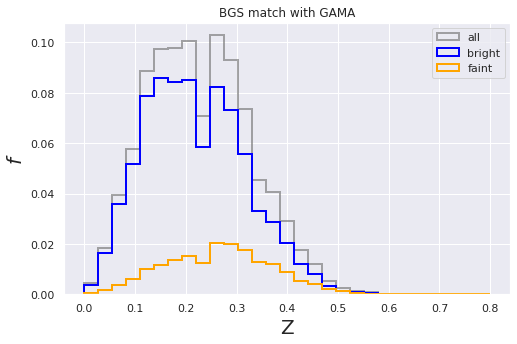

In [37]:
plt.figure(figsize=(8,5))

N = np.sum((dr8_gama) & (bgs))
cumu = False

mask = (dr8_gama) & (dr8_z > 0) & (dr8_z < 0.8) & (bgs)
maskB = (dr8_gama) & (dr8_z > 0) & (dr8_z < 0.8) & (dr8ingama['RMAG'] < 19.5) & (bgs)
maskF = (dr8_gama) & (dr8_z > 0) & (dr8_z < 0.8) & (dr8ingama['RMAG'] > 19.5) & (dr8ingama['RMAG'] < 20.) & (bgs)
bins = np.linspace(0,0.8,30)

plt.title(r'BGS match with GAMA')
plt.hist(dr8_z[mask], bins=bins,  weights=np.full(np.sum(mask), 1/N), histtype='step', cumulative=cumu, lw=2, color='gray', alpha=0.7, label='all')
plt.hist(dr8_z[maskB], bins=bins,  weights=np.full(np.sum(maskB), 1/N), histtype='step', cumulative=cumu, lw=2, color='blue', label='bright')
plt.hist(dr8_z[maskF], bins=bins,  weights=np.full(np.sum(maskF), 1/N), histtype='step', cumulative=cumu, lw=2, color='orange', label='faint')
#plt.hist(dr8_z[(maskB) & (bgs)], bins=bins,  weights=np.full(np.sum((maskB) & (bgs)), 1/N), histtype='step', cumulative=cumu, lw=2, ls='--', color='blue')
#plt.hist(dr8_z[(maskF) & (bgs)], bins=bins,  weights=np.full(np.sum((maskF) & (bgs)), 1/N), histtype='step', cumulative=cumu, lw=2, ls='--', color='orange')
plt.xlabel(r'Z', size=20)
plt.ylabel(r'$f$', size=20)
plt.legend()

In [24]:
#
def hexbin(secmask=None, title=None, C=None, clab=None):
    
    '''
    fig,ax = plt.subplots(1,2, figsize=(18,8))
    fig.suptitle(title, fontsize=16)
    
    y = (dr8ingama['RMAG'] - dr8_rmodel)

    #ylim = np.percentile(dr8_rmodel[(dr8_rmodel > 0) & (np.isfinite(dr8_rmodel))],(0,99.9))
    ylim = np.percentile(y[dr8_gama][np.isfinite(y[dr8_gama])],(0.2,99.8))
    xlim = np.percentile(dr8ingama['RMAG'],(2,100))
    mask0 = (y > ylim[0]) & (y < ylim[1]) & (dr8_gama) & (secmask)
    print(ylim[0], ylim[1])
    
    z = np.polyfit(dr8ingama['RMAG'][mask0], y[mask0], 1)
    z2 = np.polyfit(dr8ingama['RMAG'][mask0], y[mask0], 2)
    x = np.linspace(xlim[0], xlim[1], 20)
    y1 = z[0]*x + z[1]
    y2 = z2[0]*x**(2) + z2[1]*x + z2[2]
    
    print('(linear): rmag-RMOD = (%2.3g)rmag + (%2.3g)' %(z[0], z[1]))
    print(r'(non-linear): rmag-RMOD = (%2.3g)rmag$^2$ + (%2.3g)rmag + (%2.3g)' %(z2[0], z2[1], z2[2]))

    #ax[0].text(16.7, 17, 'RMOD = (%2.3g)rmag + (%2.3g)' %(z[0], z[1]), size=10, c='k')
    #ax[0].text(16.7, 16.7, r'RMOD = (%2.3g)rmag$^2$ + (%2.3g)rmag + (%2.3g)' %(z2[0], z2[1], z2[2]), size=10, c='r')

    tot = np.sum(mask0)
    colors = ['blue', 'orange', 'green', 'red', 'purple']

    for i, morph in enumerate(['DEV ', 'EXP ', 'REX ', 'COMP', 'PSF ']):
    
        mask = (mask0) & (dr8ingama['TYPE'] == morph)
        f = np.sum(mask)/tot
        if f < 0.1: s, alpha, col = 3, 0.4, colors[i]
        else: s, alpha, col = 0.3, 0.6, colors[i]
        ax[0].scatter(dr8ingama['RMAG'][mask], y[mask], s=s, alpha=alpha, color=col, label='%s, f=%2.3g' %(morph, f))

    
    ax[0].plot(x,y1, marker='*', c='k')
    ax[0].plot(x,y2, marker='*', c='r')
    ax[0].axhline(0, ls='--', lw=2, c='k')

    ax[0].set_xlabel(r'rmag LS', size=15)
    ax[0].set_ylabel(r'rmag - R_PETRO', size=15)
    lgnd = ax[0].legend()
    [handle.set_sizes([18.0]) for handle in lgnd.legendHandles]
            
    # ------------------------------------
    ax[1].plot(x,y1, marker='*', c='k')
    ax[1].plot(x,y2, marker='*', c='r')

    C=None
    bins=None
    pos = ax[1].hexbin(dr8ingama['RMAG'][mask0], y[mask0], C=C, gridsize=(60,60), cmap='viridis', bins=bins, 
                           mincnt=1, alpha=0.8)
    ax[1].set_xlabel(r'rmag LS', size=15)
    ax[1].axhline(0, ls='--', lw=2, c='k')
        
    #cbaxes = fig.add_axes([1, 0.1, 0.03, 0.8])
    fig.colorbar(pos, ax=ax[1], label=r'$N$')

    # -------------------------------------------
    '''
    
    fig,ax = plt.subplots(1,5, figsize=(22,4))
    
    y = (dr8ingama['RMAG'] - dr8_rmodel)
    ylim = np.percentile(y[dr8_gama][np.isfinite(y[dr8_gama])],(0.2,99.7))
    xlim = np.percentile(dr8ingama['RMAG'],(2,100))
    mask0 = (y > ylim[0]) & (y < ylim[1]) & (dr8_gama) & (secmask)
    tot = np.sum(mask0)
    
    print('GENERAL: median = %2.3g, mean = %2.3g' %(np.median(y[mask0]), np.mean(y[mask0])))

    for i, morph in enumerate(['DEV ', 'EXP ', 'REX ', 'COMP', 'PSF ']):
    
        mask = (mask0) & (dr8ingama['TYPE'] == morph)
        f = np.sum(mask)/tot
        #if f < 0.1: s, alpha, col = 3, 0.6, colors[i]
        #else: s, alpha, col = 0.3, 0.6, colors[i]
        if C is not None: C0 = C[mask]
        else: C0 = None
        
        bins=None
        ax[i].set_title(r'%s' %(morph), size=15)
        pos = ax[i].hexbin(dr8ingama['RMAG'][mask], y[mask], C=C0, gridsize=(50,50), cmap='viridis', bins=bins, 
                           mincnt=1, alpha=0.8)
        
        if clab is None: clab = r'$N$'
        fig.colorbar(pos, ax=ax[i], orientation="horizontal", pad=0.2, label=clab)
        
        ymean, ymedian = np.mean(y[mask]), np.median(y[mask])
        
        dx = np.abs(xlim[1] - xlim[0])/15.
        dy = np.abs(ylim[1] - ylim[0])/15.
        ax[i].text(xlim[0]+dx, ylim[1]-dy, r'f. %2.3g' %(f), size=12)
        #ax[i].plot(x,y1, marker='*', c='k')
        #ax[i].plot(x,y2, marker='*', c='r')
        ax[i].axhline(0, ls=':', lw=2, c='k')
        #ax[i].axhline(ymean, ls='--', lw=2, c='r', label='mean=%2.3g' %(ymean))
        ax[i].axhline(ymedian, ls='--', lw=2, c='r', label='median=%2.3g' %(ymedian))

        ax[i].set_xlabel(r'rmag LS', size=15)
        ax[i].set_xlim(xlim[0], xlim[1])
        ax[i].set_ylim(ylim[0], ylim[1])
        ax[i].legend()
        #[handle.set_sizes([18.0]) for handle in lgnd.legendHandles]
    
    ax[0].set_ylabel(r'rmag - R_PETRO', size=15)


GENERAL: median = -0.124, mean = -0.136


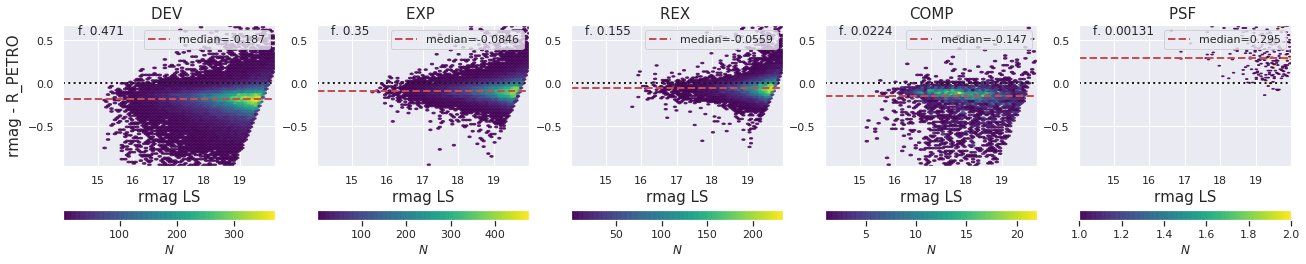

In [25]:
hexbin(secmask=bgs, title='GAMA & BGS')

GENERAL: median = 0.000772, mean = 0.0197


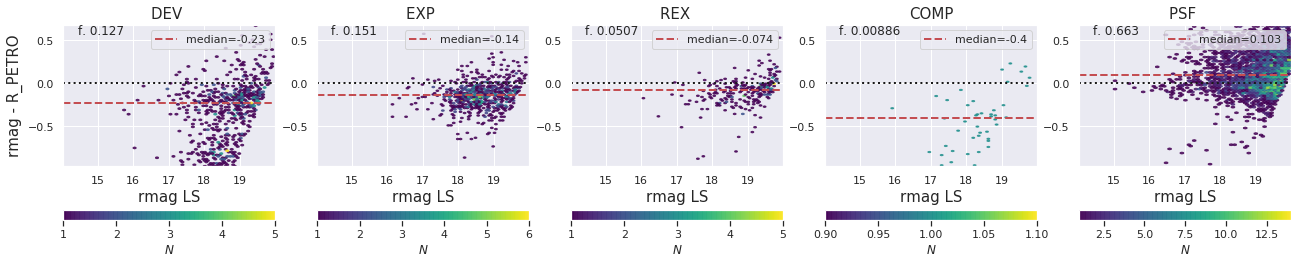

In [26]:
hexbin(secmask=~bgs, title='GAMA & ~BGS')

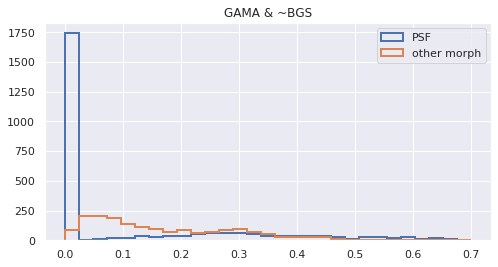

In [27]:
#
fig = plt.figure(figsize=(8,4))
keeppsf = (dr8_gama) & (~bgs) & (dr8ingama['TYPE'] == 'PSF ')
keepother = (dr8_gama) & (~bgs) & (dr8ingama['TYPE'] != 'PSF ')
bins = np.linspace(0, 0.7, 30)
plt.title(r'GAMA & ~BGS')
plt.hist(dr8_z[keeppsf], bins=bins, histtype='step', lw=2, label='PSF')
plt.hist(dr8_z[keepother], bins=bins, histtype='step', lw=2, label='other morph')
plt.legend()
plt.show()


-------- DR8 in GAMA & in GAIA but not in BGS --------
	 BS: 0
	 MS: 199
	 GC: 0
	 LG: 0
	 allmask: 0
	 nobs: 0
	 SG: 3505
	 FMC: 0
	 CC: 4
	 QC_FM: 89
	 QC_FI: 30
	 QC_FF: 28
	 QC_IVAR: 2
-------- DR8 in GAMA but not in BGS --------
	 BS: 0
	 MS: 377
	 GC: 0
	 LG: 0
	 allmask: 1
	 nobs: 0
	 SG: 3505
	 FMC: 835
	 CC: 49
	 QC_FM: 501
	 QC_FI: 263
	 QC_FF: 265
	 QC_IVAR: 18


Text(0, 0.5, 'N')

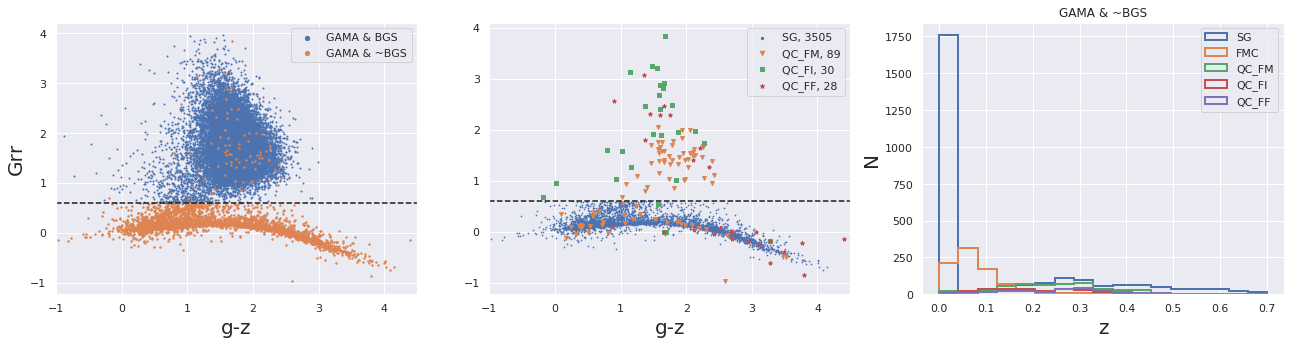

In [42]:
#
from main_def import bgsmask
plt.figure(figsize=(22, 5))

Grr = dr8ingama['G'] - 22.5 + 2.5*np.log10(dr8ingama['FLUX_R'])
gz = dr8ingama['GMAG'] - dr8ingama['ZMAG']

ylim = np.percentile(Grr[dr8ingama['G'] != 0][np.isfinite(Grr[dr8ingama['G'] != 0])],(0.,99.999))

mask0 = (Grr > ylim[0]) & (Grr < ylim[1]) & (dr8_gama) & (bgs) & (dr8ingama['G'] != 0)
mask1 = (Grr > ylim[0]) & (Grr < ylim[1]) & (dr8_gama) & (~bgs) & (dr8ingama['G'] != 0)

plt.subplot(1, 3, 1)
plt.scatter(gz[mask0], Grr[mask0], s=1, label='GAMA & BGS')
plt.scatter(gz[mask1], Grr[mask1], s=2, label='GAMA & ~BGS')

plt.xlabel(r'g-z', size=20)
plt.ylabel(r'Grr', size=20)
plt.xlim(-1, 4.5)
plt.axhline(0.6, ls='--', c='k')
lgnd = plt.legend()
[handle.set_sizes([18.0]) for handle in lgnd.legendHandles]

plt.subplot(1, 3, 2)
print('-------- DR8 in GAMA & in GAIA but not in BGS --------')
#bgsmask = bgsmask()
markers = ['.', 'v', 's', '*', 'd', 'x']
for key, val in zip(bgsmask().keys(), bgsmask().values()):
    mask = (mask1) & ((dr8ingama['BGSBITS'] & 2**(val)) == 0)
    print('\t %s: %i' %(key, np.sum(mask)))
for i, key in enumerate(['SG', 'QC_FM', 'QC_FI', 'QC_FF']):
    mask = (mask1) & ((dr8ingama['BGSBITS'] & 2**(bgsmask()[key])) == 0)
    if np.sum(mask) < 100: s = 15
    elif np.sum(mask) > 1000: s = 2
    else: s = 1
    plt.scatter(gz[mask], Grr[mask], s=s, marker=markers[i], label='%s, %i' %(key, np.sum(mask)))
        
plt.xlabel(r'g-z', size=20)
#plt.ylabel(r'Grr', size=20)
plt.xlim(-1, 4.5)
plt.axhline(0.6, ls='--', c='k')
lgnd = plt.legend()
[handle.set_sizes([20]) for handle in lgnd.legendHandles]
#plt.show()

plt.subplot(1, 3, 3)
print('-------- DR8 in GAMA but not in BGS --------')
keep = (dr8_gama) & (~bgs)
bins = np.linspace(0, 0.7, 18)
plt.title(r'GAMA & ~BGS')
for key, val in zip(bgsmask().keys(), bgsmask().values()):
    mask = (keep) & ((dr8ingama['BGSBITS'] & 2**(val)) == 0)
    print('\t %s: %i' %(key, np.sum(mask)))
for i, key in enumerate(['SG', 'FMC', 'QC_FM', 'QC_FI', 'QC_FF']):
    mask = (keep) & ((dr8ingama['BGSBITS'] & 2**(bgsmask()[key])) == 0)
    plt.hist(dr8_z[mask], bins=bins, histtype='step', lw=2, label=key)
plt.legend()
plt.xlabel(r'z', size=20)
plt.ylabel(r'N', size=20)


# DEV ZONE...